In [1]:
import nshtrainer.ll as ll
import rich

ll.pretty()

TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.


In [2]:
acts = ll.ActLoad.from_latest_version(
    "/workspaces/repositories/jmp-peft/config/relax/lltrainer/nz809rlq/activation"
)
rich.print(acts)

ActLoad({'validation.batch': <1024 activations>,
 'validation.edge_index': <1024 activations>,
 'validation.h_0': <1024 activations>,
 'validation.h_1': <1024 activations>,
 'validation.h_2': <1024 activations>,
 'validation.h_3': <1024 activations>,
 'validation.h_4': <1024 activations>,
 'validation.h_5': <1024 activations>,
 'validation.m_0': <1024 activations>,
 'validation.m_1': <1024 activations>,
 'validation.m_2': <1024 activations>,
 'validation.m_3': <1024 activations>,
 'validation.m_4': <1024 activations>,
 'validation.m_5': <1024 activations>,
 'validation.natoms': <1024 activations>,
 'validation.pos': <1024 activations>,
 'validation.x_E_0': <1024 activations>,
 'validation.x_E_1': <1024 activations>,
 'validation.x_E_2': <1024 activations>,
 'validation.x_E_3': <1024 activations>,
 'validation.x_E_4': <1024 activations>,
 'validation.x_E_5': <1024 activations>,
 'validation.x_E_6': <1024 activations>,
 'validation.x_E_final': <1024 activations>,
 'validation.x_F_0': <1024 activations>,
 'validation.x_F_1': <1024 activations>,
 'validation.x_F_2': <1024 activations>,
 'validation.x_F_3': <1024 activations>,
 'validation.x_F_4': <1024 activations>,
 'validation.x_F_5': <1024 activations>,
 'validation.x_F_6': <1024 activations>,
 'validation.x_F_final': <1024 activations>})

In [3]:
# prefix = "validation.m_"
prefix = "validation.h_"
acts_list = [act for act in acts if act.name.startswith(prefix)]
rich.print(acts_list)

[
    <LoadedActivation validation.h_0 (1024 activations)>,
    <LoadedActivation validation.h_1 (1024 activations)>,
    <LoadedActivation validation.h_2 (1024 activations)>,
    <LoadedActivation validation.h_3 (1024 activations)>,
    <LoadedActivation validation.h_4 (1024 activations)>,
    <LoadedActivation validation.h_5 (1024 activations)>
]

In [5]:
from collections.abc import Callable

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm

sns.set_theme()


def plot(data: dict[str, np.ndarray], title: str | None = None):
    fig, ax = plt.subplots()
    for name, m in data.items():
        sns.histplot(m, kde=True, label=name, ax=ax)

    ax.legend()
    if title is not None:
        plt.title(title)
    plt.show()


def plot_stacked(
    prefix: str,
    process_fn: Callable[[np.ndarray], np.ndarray] = lambda x: np.linalg.norm(
        x, axis=-1
    ),
):
    acts_list = [act for act in acts if act.name.startswith(prefix)]

    stacked = {
        act.name.rsplit(".")[-1]: process_fn(np.concatenate(act.all_activations()))
        for act in tqdm(acts_list)
    }

    plot(stacked, title=f"`{prefix}` activations")


def plot_averaged(prefix: str):
    acts_list = [act for act in acts if act.name.startswith(prefix)]

    data: dict[str, np.ndarray] = {}
    for act in tqdm(acts_list):
        layer = act.name.rsplit(".")[-1]
        norms = np.stack(
            [np.linalg.norm(a, axis=1).mean(axis=0) for a in act.all_activations()]
        )
        data[layer] = norms

    plot(data, title=f"`{prefix}` activations")

In [6]:
num_neighbors_list = []
for act in tqdm(acts["validation.edge_index"]):
    # act: (2, num_edges), where acts[0] is the source and acts[1] is the target
    # Let's find the number of neighbors for each atom
    num_neighbors = np.bincount(act[0], minlength=act[0].max() + 1).mean()
    num_neighbors_list.append(num_neighbors)


# sizes = np.concatenate(acts["validation.natoms"].all_activations())
sizes = np.array(num_neighbors_list)
rich.print(sizes)

  0%|          | 0/1024 [00:00<?, ?it/s]

array[1024] 8Kb x∈[19.654, 33.333] μ=29.921 σ=1.760

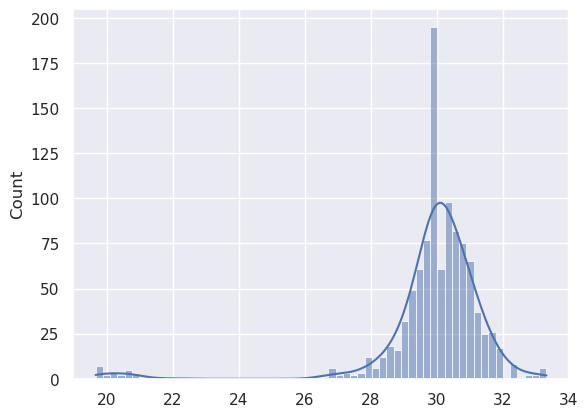

array[3] i64 x∈[29, 31] μ=30.000 σ=0.816 [29, 30, 31] array[1024] i64 8Kb x∈[0, 3] μ=1.702 σ=0.875

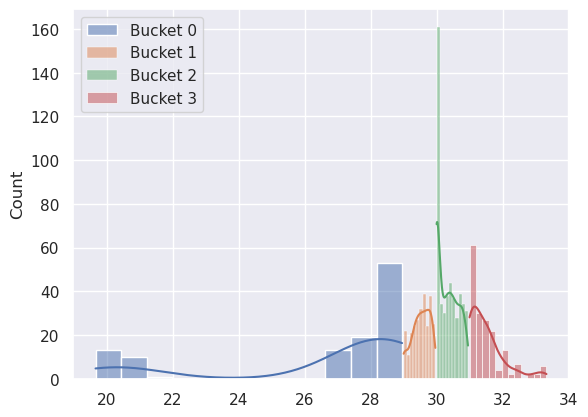

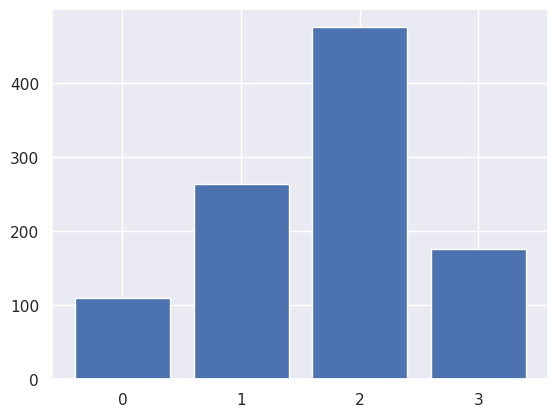

In [7]:
sns.histplot(sizes, kde=True)
plt.show()

N = 5
# Let's distribute the systems into N buckets based on the number of atoms
# We can do this automatically by using the quantiles of the number of atoms
q = np.linspace(0, 1, N + 1)
q = q[1:-1]  # Remove the first and last quantile (0 and 1) to avoid empty buckets
quantiles = np.quantile(sizes, q)
# Make sure that the quantiles are integers and distinct
quantiles = np.unique(np.round(quantiles).astype(int))
buckets = np.digitize(sizes, quantiles)
rich.print(quantiles, buckets)

# Re-draw the histogram with the buckets colored in
for i in range(buckets.max() + 1):
    sns.histplot(sizes[buckets == i], kde=True, label=f"Bucket {i}")
plt.legend()
plt.show()

# Show a bar plot for the number of systems in each bucket
unique, counts = np.unique(buckets, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique)
plt.show()

[12:01:23] CRITICAL Type checking the following modules: ('jmppeft',)                               ]8;id=870217;file:///workspaces/ll/src/ll/typecheck.py\typecheck.py]8;;\:]8;id=626720;file:///workspaces/ll/src/ll/typecheck.py#65\65]8;;\

  0%|          | 0/6 [00:00<?, ?it/s]

{
    'h_0': array[30392] f32 0.1Mb x∈[4.034, 33.007] μ=16.029 σ=4.368,
    'h_1': array[30392] f32 0.1Mb x∈[8.552, 34.202] μ=17.010 σ=3.364,
    'h_2': array[30392] f32 0.1Mb x∈[11.080, 40.006] μ=18.530 σ=3.267,
    'h_3': array[30392] f32 0.1Mb x∈[13.900, 36.119] μ=22.284 σ=2.841,
    'h_4': array[30392] f32 0.1Mb x∈[16.345, 79.845] μ=31.809 σ=4.683,
    'h_5': array[30392] f32 0.1Mb x∈[11.440, 57.608] μ=28.670 σ=7.319
}

array[30392] i64 0.2Mb x∈[0, 3] μ=1.560 σ=0.916
buckets_expanded.shape=(30392,), data['h_0'].shape=(30392,)


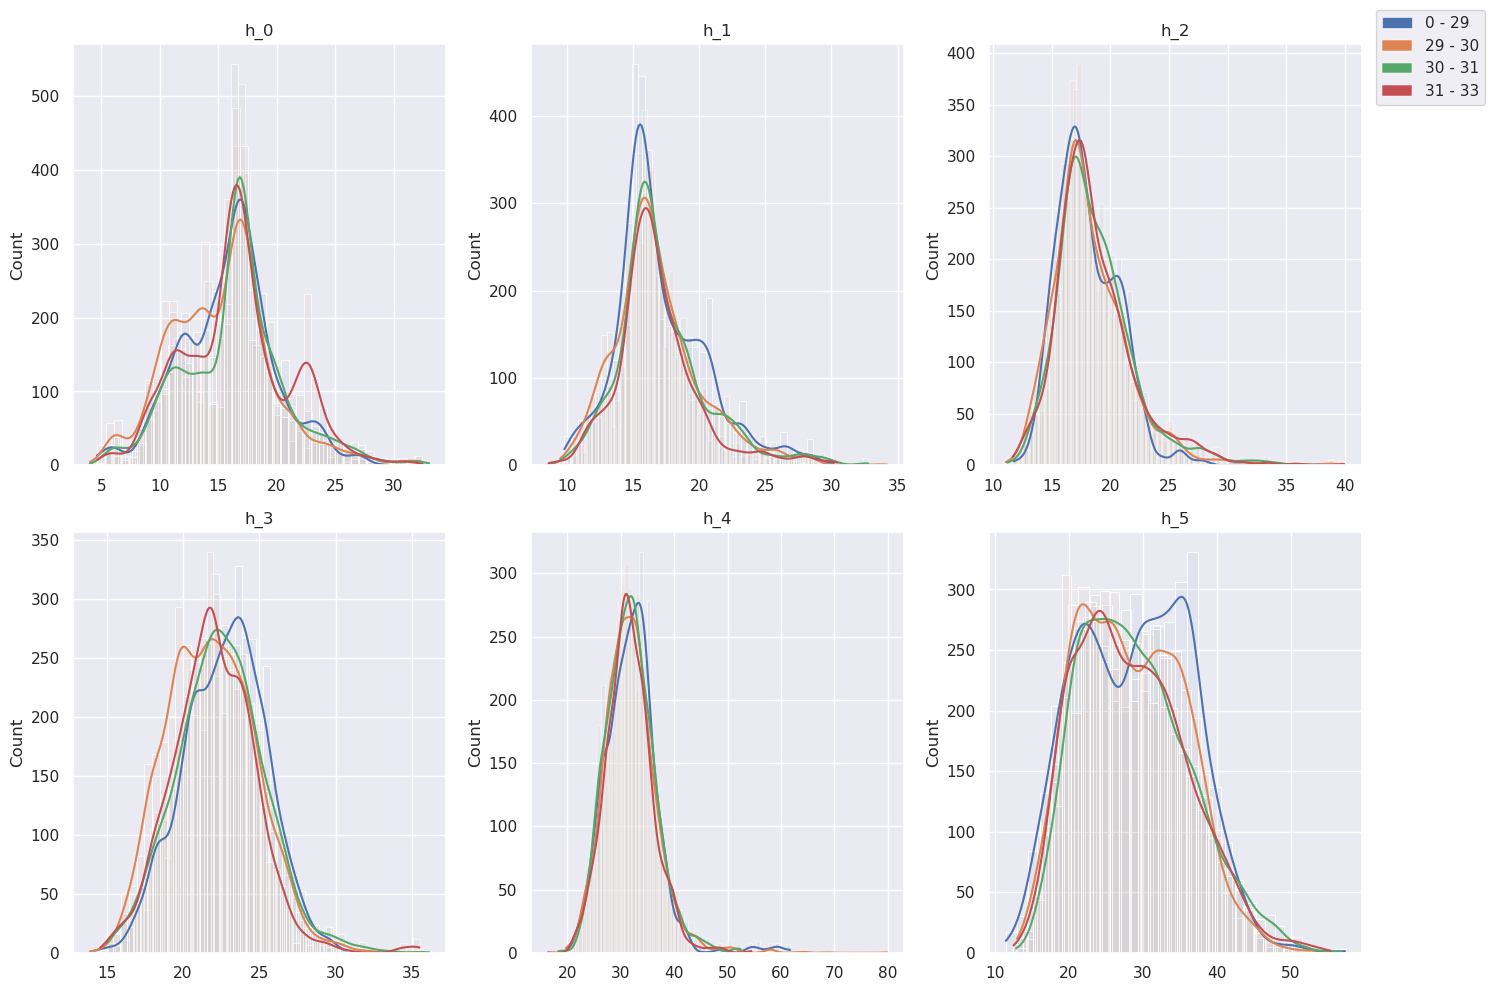

In [8]:
from jmppeft.utils.plotting.act_analysis import (
    plot_values_buckets,
    plot_values_buckets_sampled,
)

# Draw the h activations with the buckets set to the hatch.
# This means we will have two legends: one for the buckets and one for the layers
acts_list = [act for act in acts if act.name.startswith("validation.h_")]

buckets_expanded_list = []
data: dict[str, np.ndarray] = {}
for i, act in enumerate(tqdm(acts_list)):
    layer = act.name.rsplit(".")[-1]
    l: list[np.ndarray] = []
    for a_idx, a in enumerate(act.all_activations()):
        a = np.linalg.norm(a, axis=-1)
        l.append(a)

        if i == 0:
            buckets_expanded_list.extend([buckets[a_idx]] * len(a))
    norms = np.concatenate(l)
    data[layer] = norms

rich.print(data)
buckets_expanded = np.array(buckets_expanded_list)
print(buckets_expanded)
quantiles_list = np.array([0.0, *quantiles, sizes.max()])

print(f"{buckets_expanded.shape=}, {data['h_0'].shape=}")
# ^ buckets_expanded.shape=(30392,), data['h_0'].shape=(30392,)

if False:
    plot_values_buckets(data, buckets_expanded, quantiles_list, ncols=3)
plot_values_buckets_sampled(data, buckets_expanded, quantiles_list, ncols=3)

  0%|          | 0/6 [00:00<?, ?it/s]

{
    'm_0': array[887592] f32 3.4Mb x∈[15.190, 103.037] μ=24.186 σ=7.957,
    'm_1': array[887592] f32 3.4Mb x∈[12.948, 43.058] μ=17.137 σ=2.089,
    'm_2': array[887592] f32 3.4Mb x∈[12.717, 76.183] μ=19.687 σ=4.393,
    'm_3': array[887592] f32 3.4Mb x∈[11.775, 69.150] μ=18.334 σ=3.396,
    'm_4': array[887592] f32 3.4Mb x∈[14.470, 109.082] μ=24.427 σ=4.674,
    'm_5': array[887592] f32 3.4Mb x∈[20.290, 218.912] μ=54.242 σ=27.483
}

array[887592] i64 6.8Mb x∈[0, 3] μ=1.631 σ=0.885


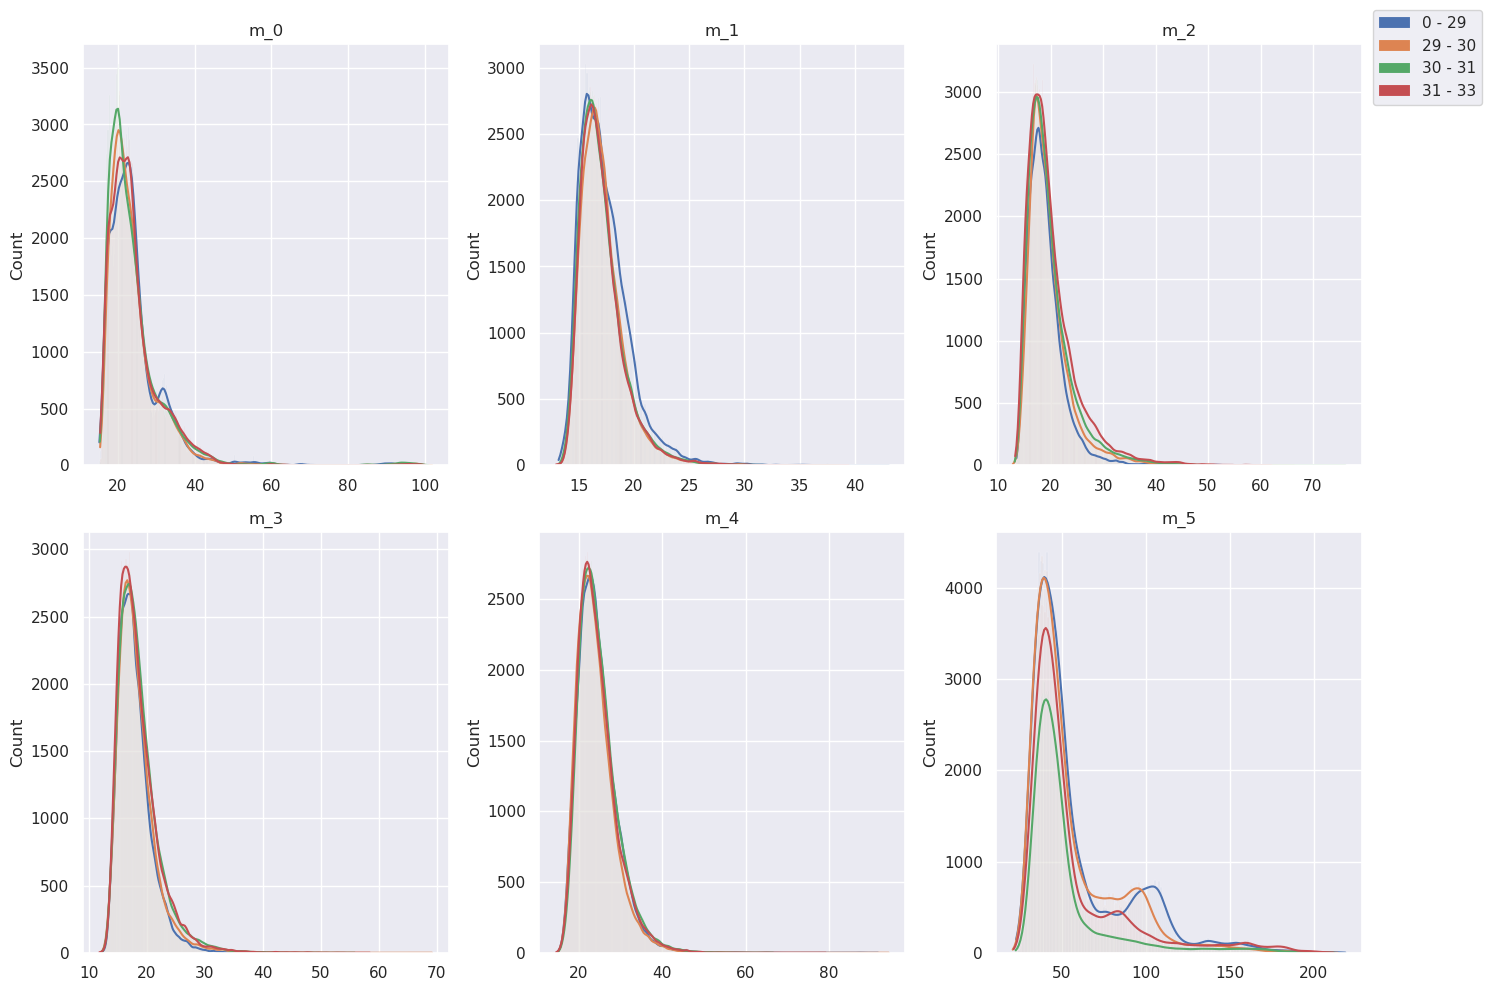

In [9]:
from jmppeft.utils.plotting.act_analysis import (
    plot_values_buckets,
    plot_values_buckets_sampled,
)

# Draw the h activations with the buckets set to the hatch.
# This means we will have two legends: one for the buckets and one for the layers
acts_list = [act for act in acts if act.name.startswith("validation.m_")]

buckets_expanded_list = []
data: dict[str, np.ndarray] = {}
for i, act in enumerate(tqdm(acts_list)):
    layer = act.name.rsplit(".")[-1]
    l: list[np.ndarray] = []
    for a_idx, a in enumerate(act.all_activations()):
        a = np.linalg.norm(a, axis=-1)
        l.append(a)

        if i == 0:
            buckets_expanded_list.extend([buckets[a_idx]] * len(a))
    norms = np.concatenate(l)
    data[layer] = norms

rich.print(data)
buckets_expanded = np.array(buckets_expanded_list)
print(buckets_expanded)
quantiles_list = np.array([0.0, *quantiles, sizes.max()])

if False:
    plot_values_buckets(data, buckets_expanded, quantiles_list, ncols=3)
plot_values_buckets_sampled(data, buckets_expanded, quantiles_list, ncols=3)

  0%|          | 0/8 [00:00<?, ?it/s]

{
    'x_E_0': array[30392] f32 0.1Mb x∈[4.418, 71.523] μ=14.780 σ=9.273,
    'x_E_1': array[30392] f32 0.1Mb x∈[2.792, 35.607] μ=7.197 σ=4.461,
    'x_E_2': array[30392] f32 0.1Mb x∈[2.451, 64.621] μ=7.781 σ=4.255,
    'x_E_3': array[30392] f32 0.1Mb x∈[3.110, 49.094] μ=6.481 σ=2.958,
    'x_E_4': array[30392] f32 0.1Mb x∈[3.544, 33.232] μ=6.278 σ=1.838,
    'x_E_5': array[30392] f32 0.1Mb x∈[3.742, 74.388] μ=7.527 σ=2.781,
    'x_E_6': array[30392] f32 0.1Mb x∈[2.163, 76.954] μ=4.852 σ=2.284,
    'x_E_final': array[30392] f32 0.1Mb x∈[1.437, 70.318] μ=5.453 σ=4.888
}

array[30392] i64 0.2Mb x∈[0, 3] μ=1.560 σ=0.916


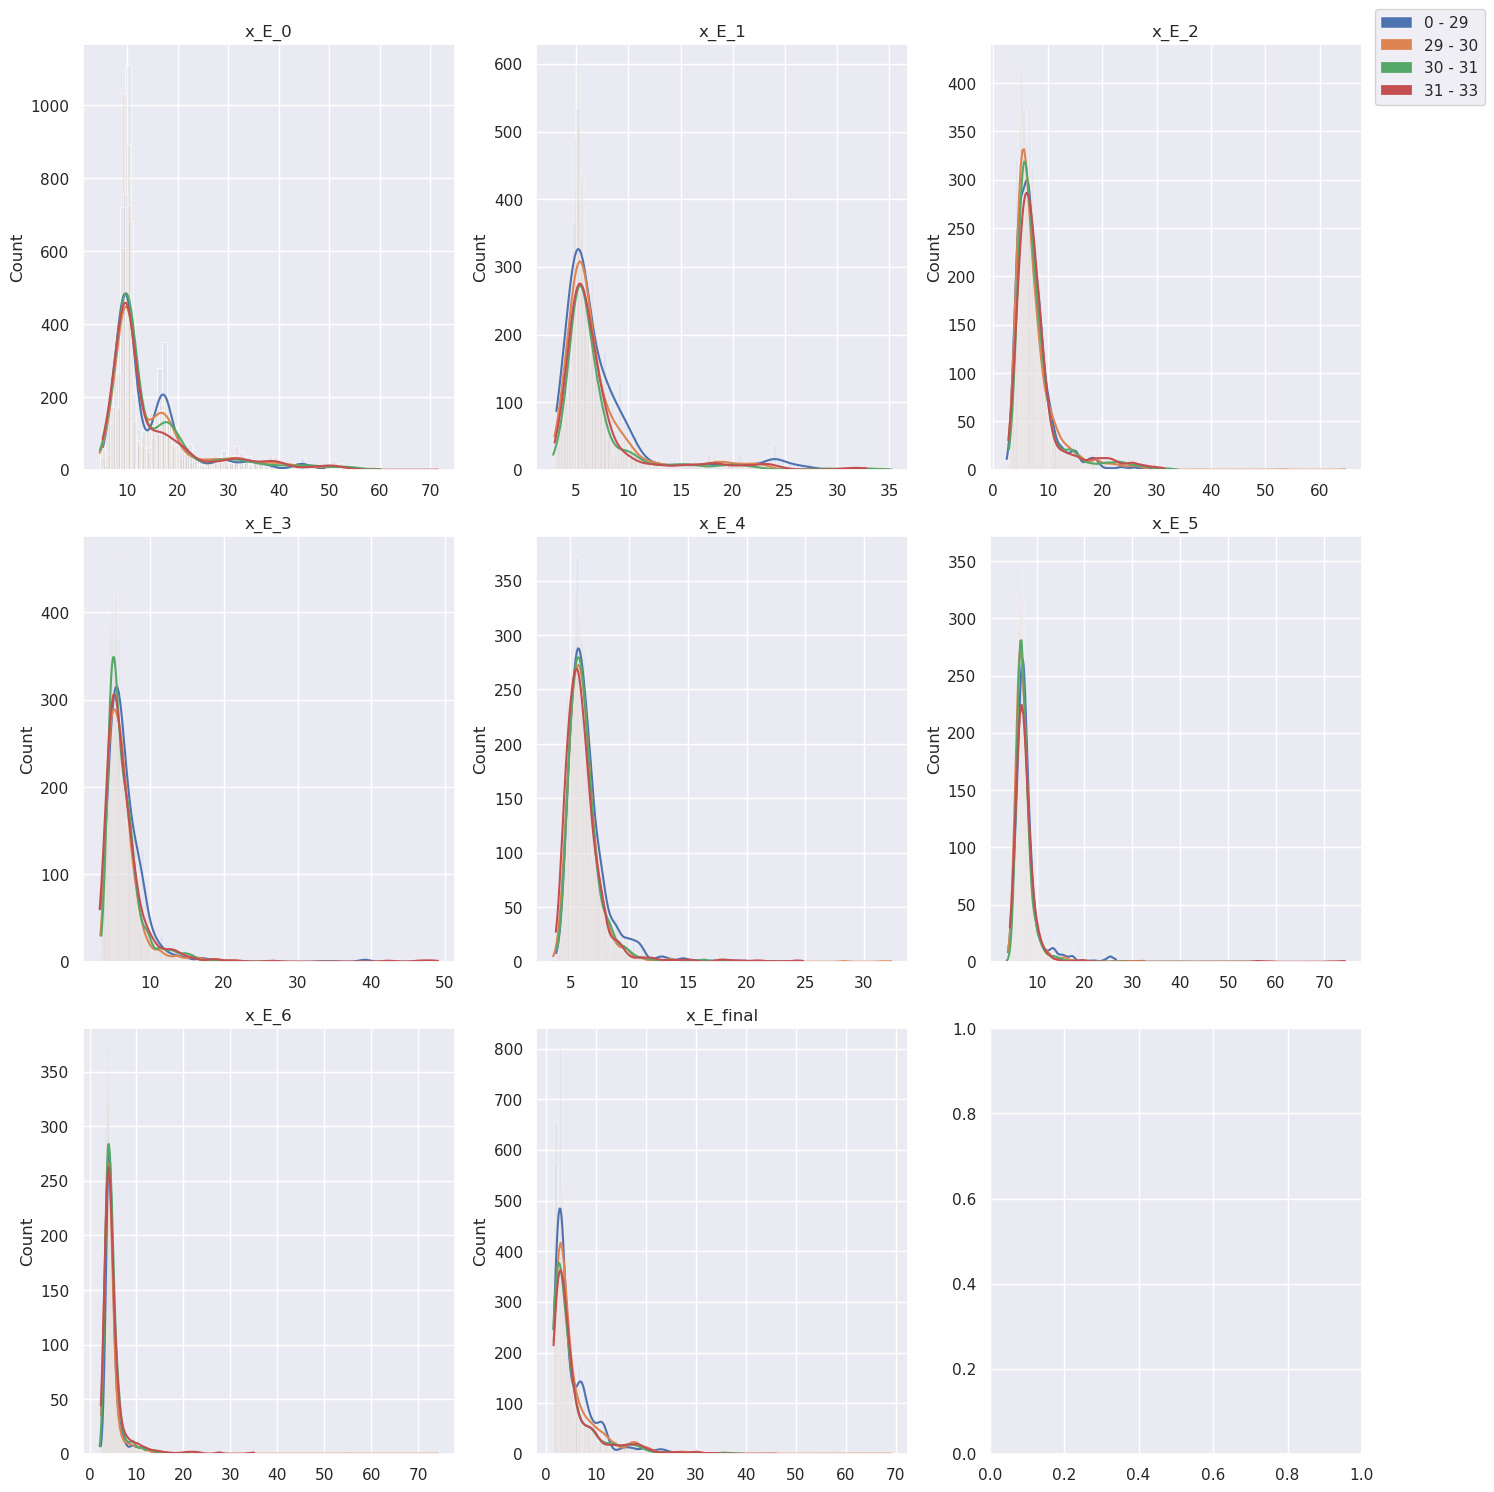

In [12]:
from jmppeft.utils.plotting.act_analysis import (
    plot_values_buckets,
    plot_values_buckets_sampled,
)

# Draw the h activations with the buckets set to the hatch.
# This means we will have two legends: one for the buckets and one for the layers
acts_list = [act for act in acts if act.name.startswith("validation.x_E_")]

buckets_expanded_list = []
data: dict[str, np.ndarray] = {}
for i, act in enumerate(tqdm(acts_list)):
    layer = act.name.rsplit(".")[-1]
    l: list[np.ndarray] = []
    for a_idx, a in enumerate(act.all_activations()):
        a = np.linalg.norm(a, axis=-1)
        l.append(a)

        if i == 0:
            buckets_expanded_list.extend([buckets[a_idx]] * len(a))
    norms = np.concatenate(l)
    data[layer] = norms

rich.print(data)
buckets_expanded = np.array(buckets_expanded_list)
print(buckets_expanded)
quantiles_list = np.array([0.0, *quantiles, sizes.max()])

if False:
    plot_values_buckets(data, buckets_expanded, quantiles_list, ncols=3)
plot_values_buckets_sampled(data, buckets_expanded, quantiles_list, ncols=3)

  0%|          | 0/8 [00:00<?, ?it/s]

{
    'x_F_0': array[887592] f32 3.4Mb x∈[12.016, 134.542] μ=120.991 σ=14.730,
    'x_F_1': array[887592] f32 3.4Mb x∈[64.882, 134.065] μ=125.406 σ=7.784,
    'x_F_2': array[887592] f32 3.4Mb x∈[63.952, 156.472] μ=148.890 σ=8.398,
    'x_F_3': array[887592] f32 3.4Mb x∈[85.985, 180.137] μ=172.789 σ=8.410,
    'x_F_4': array[887592] f32 3.4Mb x∈[78.055, 167.147] μ=152.630 σ=10.721,
    'x_F_5': array[887592] f32 3.4Mb x∈[43.615, 149.502] μ=136.803 σ=8.304,
    'x_F_6': array[887592] f32 3.4Mb x∈[95.017, 156.852] μ=152.400 σ=3.228,
    'x_F_final': array[887592] f32 3.4Mb x∈[0.136, 2.901e+04] μ=20.591 σ=88.203
}

array[887592] i64 6.8Mb x∈[0, 3] μ=1.631 σ=0.885


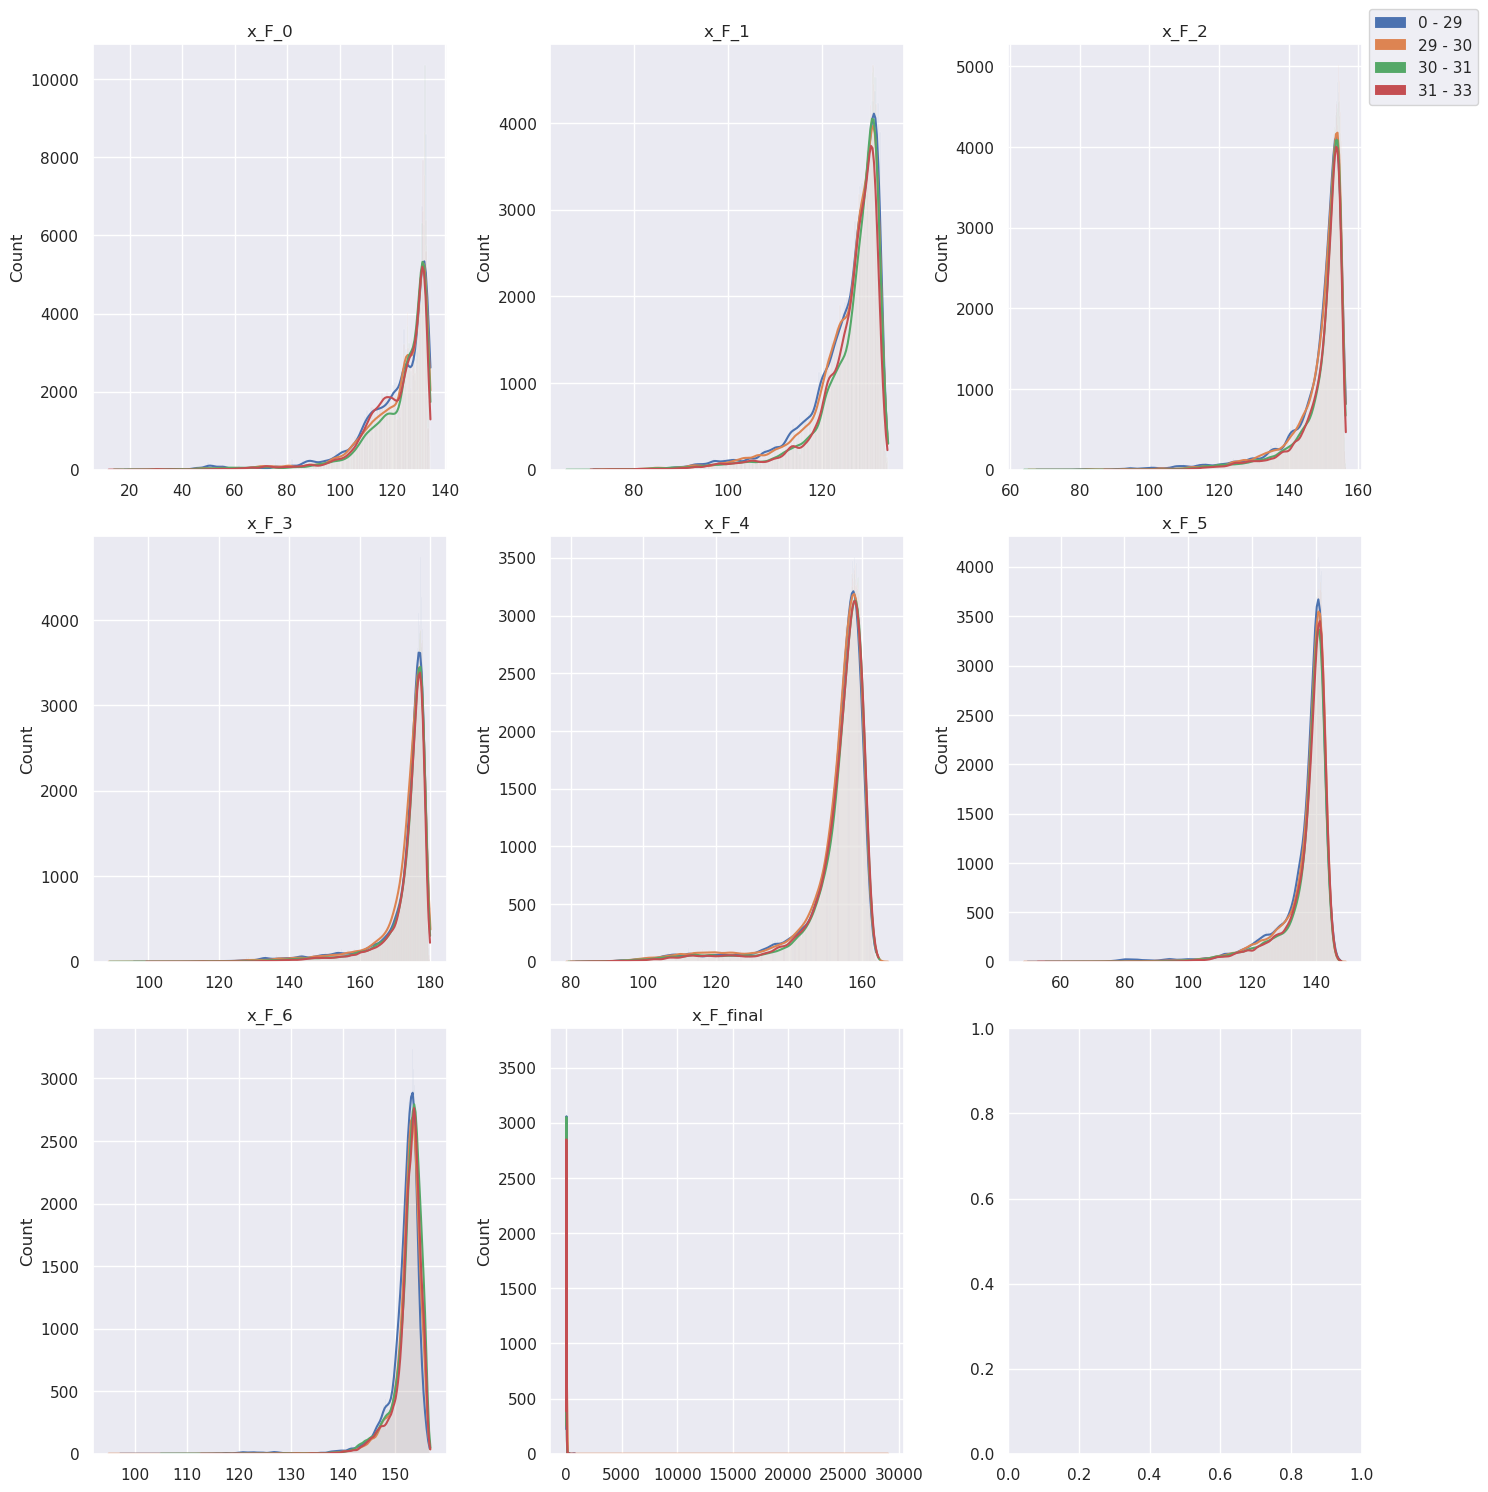

In [13]:
from jmppeft.utils.plotting.act_analysis import (
    plot_values_buckets,
    plot_values_buckets_sampled,
)

# Draw the h activations with the buckets set to the hatch.
# This means we will have two legends: one for the buckets and one for the layers
acts_list = [act for act in acts if act.name.startswith("validation.x_F_")]

buckets_expanded_list = []
data: dict[str, np.ndarray] = {}
for i, act in enumerate(tqdm(acts_list)):
    layer = act.name.rsplit(".")[-1]
    l: list[np.ndarray] = []
    for a_idx, a in enumerate(act.all_activations()):
        a = np.linalg.norm(a, axis=-1)
        l.append(a)

        if i == 0:
            buckets_expanded_list.extend([buckets[a_idx]] * len(a))
    norms = np.concatenate(l)
    data[layer] = norms

rich.print(data)
buckets_expanded = np.array(buckets_expanded_list)
print(buckets_expanded)
quantiles_list = np.array([0.0, *quantiles, sizes.max()])


if False:
    plot_values_buckets(data, buckets_expanded, quantiles_list, ncols=3)
plot_values_buckets_sampled(data, buckets_expanded, quantiles_list, ncols=3)

  0%|          | 0/6 [00:00<?, ?it/s]

{
    'h_0': array[1024] f32 4Kb x∈[5.428, 24.413] μ=14.882 σ=3.616,
    'h_1': array[1024] f32 4Kb x∈[9.128, 23.087] μ=16.239 σ=2.429,
    'h_2': array[1024] f32 4Kb x∈[11.968, 24.162] μ=17.983 σ=2.094,
    'h_3': array[1024] f32 4Kb x∈[15.245, 28.139] μ=21.403 σ=2.428,
    'h_4': array[1024] f32 4Kb x∈[21.544, 46.341] μ=30.684 σ=3.461,
    'h_5': array[1024] f32 4Kb x∈[16.853, 45.709] μ=28.368 σ=5.339
}

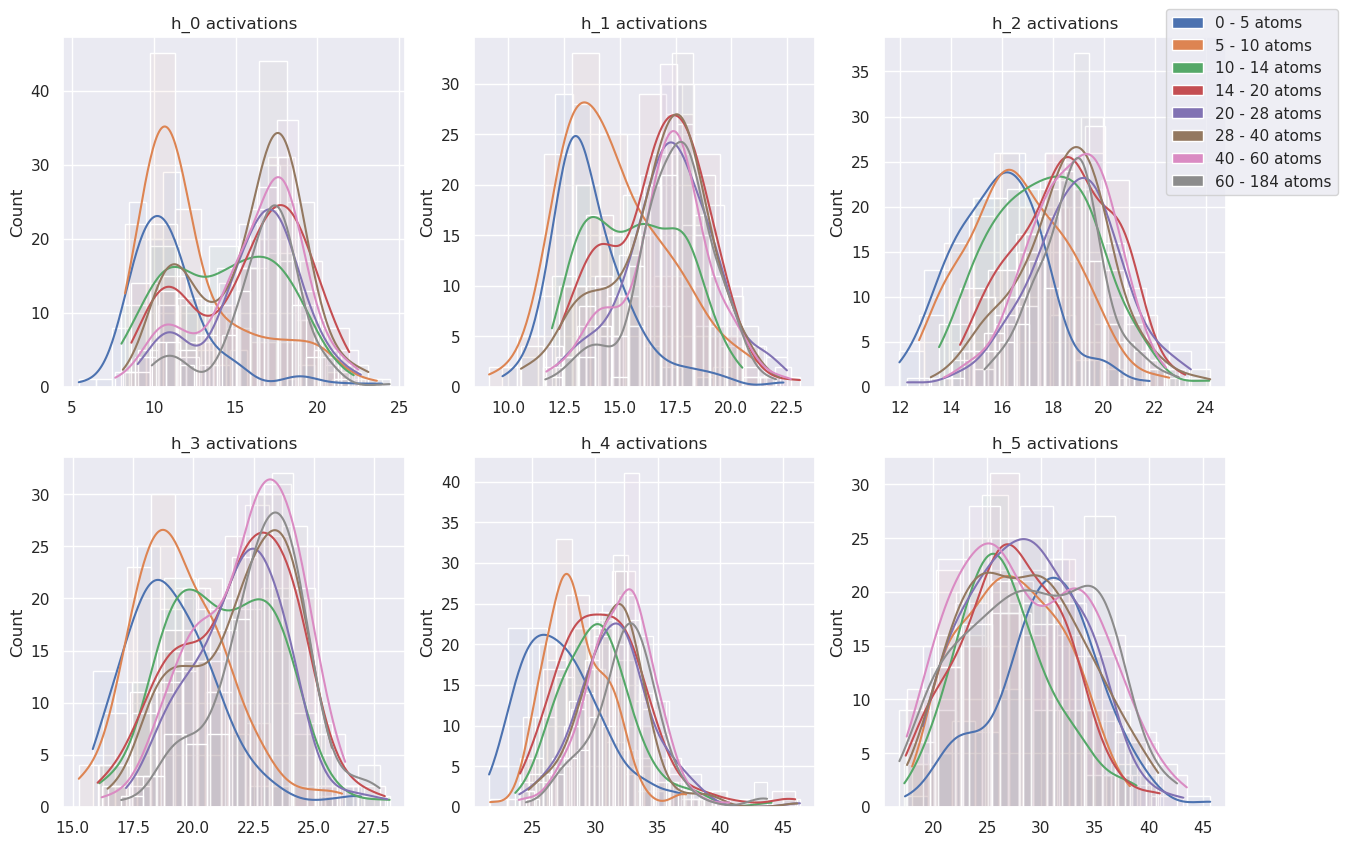

In [63]:
# Draw the h activations with the buckets set to the hatch.
# This means we will have two legends: one for the buckets and one for the layers
acts_list = [act for act in acts if act.name.startswith("validation.h_")]

data: dict[str, np.ndarray] = {}
for act in tqdm(acts_list):
    layer = act.name.rsplit(".")[-1]
    norms = np.stack(
        [np.linalg.norm(a, axis=1).mean(axis=0) for a in act.all_activations()]
    )
    data[layer] = norms

rich.print(data)

quantiles_list = [0.0, *quantiles, natoms_list.max()]

ncols = 3
nrows = len(data) // ncols + 1
if len(data) % ncols == 0:
    nrows -= 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
axes = axes.flatten()

for i, (layer, m) in enumerate(data.items()):
    ax: plt.Axes = axes[i]
    for j in range(buckets.max() + 1):
        # Set title to "{min} - {max} atoms"
        q_left = quantiles_list[j]
        q_right = quantiles_list[j + 1]
        label = f"{q_left:.0f} - {q_right:.0f} atoms"
        sns.histplot(
            m[buckets == j],
            kde=True,
            label=label,
            ax=ax,
            # Show the bars very transparently
            alpha=0.05,
        )

    if i == (ncols - 1):
        ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1))

        # Make sure legend bar colors are not transparent (like alpha above)
        for lh in ax.get_legend().legend_handles:
            if lh is None:
                continue
            lh.set_alpha(1)

    ax.set_title(f"{layer} activations")
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

{
    'm_0': array[1024] f32 4Kb x∈[20.368, 33.273] μ=24.697 σ=1.724,
    'm_1': array[1024] f32 4Kb x∈[14.518, 21.678] μ=17.117 σ=1.043,
    'm_2': array[1024] f32 4Kb x∈[15.473, 30.378] μ=19.936 σ=2.182,
    'm_3': array[1024] f32 4Kb x∈[14.556, 26.000] μ=18.398 σ=1.762,
    'm_4': array[1024] f32 4Kb x∈[17.680, 31.514] μ=23.501 σ=2.302,
    'm_5': array[1024] f32 4Kb x∈[30.813, 189.283] μ=66.741 σ=32.969
}

/tmp/ipykernel_2335523/2419084455.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax.get_legend().legendHandles:


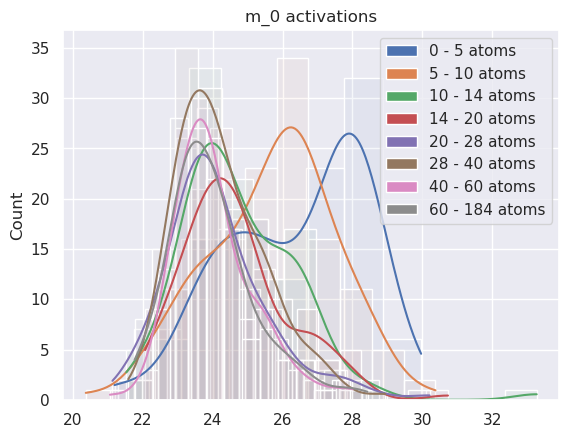

/tmp/ipykernel_2335523/2419084455.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax.get_legend().legendHandles:


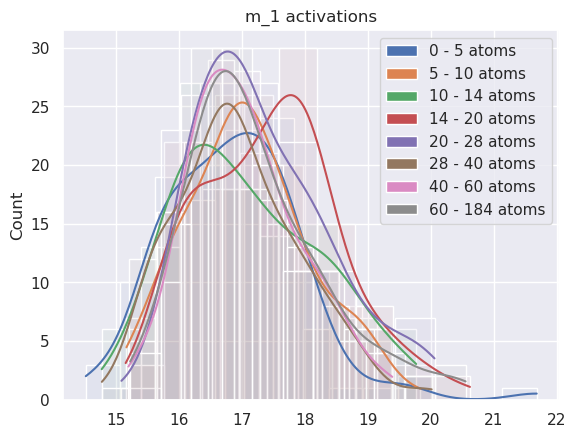

/tmp/ipykernel_2335523/2419084455.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax.get_legend().legendHandles:


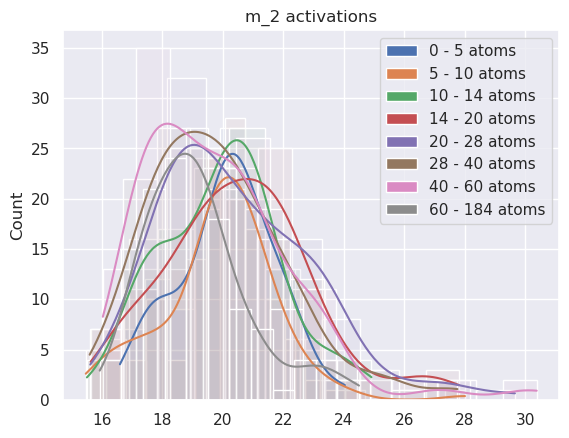

/tmp/ipykernel_2335523/2419084455.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax.get_legend().legendHandles:


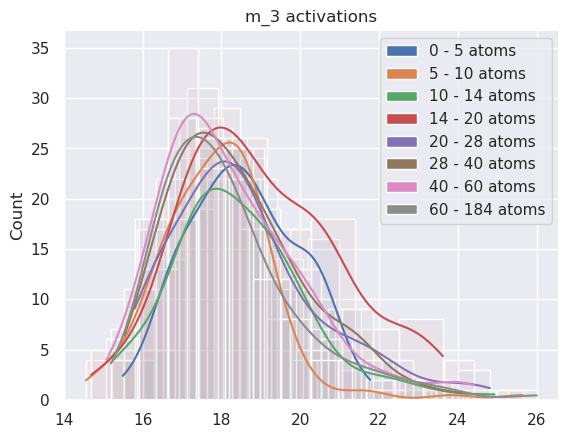

/tmp/ipykernel_2335523/2419084455.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax.get_legend().legendHandles:


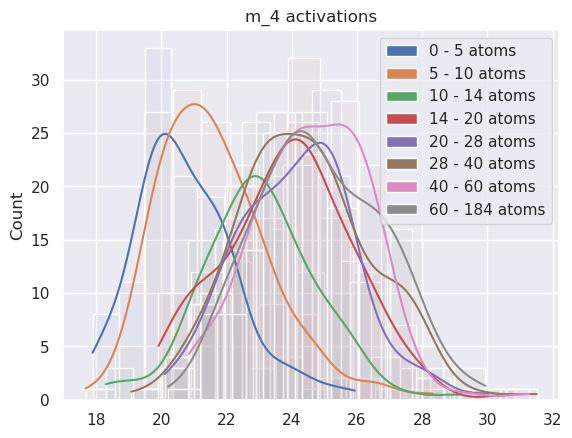

/tmp/ipykernel_2335523/2419084455.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax.get_legend().legendHandles:


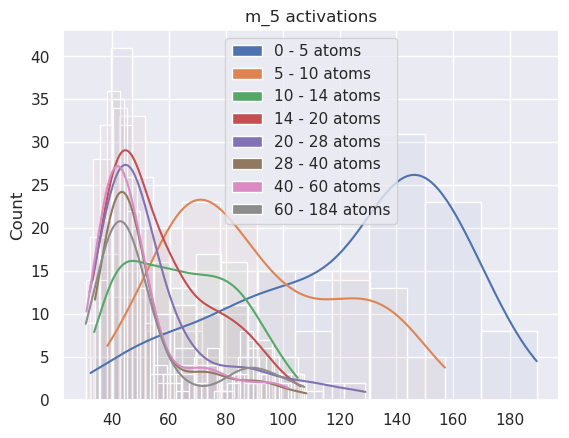

In [52]:
# Draw the h activations with the buckets set to the hatch.
# This means we will have two legends: one for the buckets and one for the layers
acts_list = [act for act in acts if act.name.startswith("validation.m_")]

data: dict[str, np.ndarray] = {}
for act in tqdm(acts_list):
    layer = act.name.rsplit(".")[-1]
    norms = np.stack(
        [np.linalg.norm(a, axis=1).mean(axis=0) for a in act.all_activations()]
    )
    data[layer] = norms

rich.print(data)

quantiles_list = [0.0, *quantiles, natoms_list.max()]
for layer, m in data.items():
    fig, ax = plt.subplots()
    for j in range(buckets.max() + 1):
        # Set title to "{min} - {max} atoms"
        q_left = quantiles_list[j]
        q_right = quantiles_list[j + 1]
        label = f"{q_left:.0f} - {q_right:.0f} atoms"
        sns.histplot(
            m[buckets == j],
            kde=True,
            label=label,
            ax=ax,
            # Show the bars very transparently
            alpha=0.05,
        )

    ax.legend()
    # Make sure legend bar colors are not transparent (like alpha above)
    for lh in ax.get_legend().legendHandles:
        lh.set_alpha(1)

    plt.title(f"{layer} activations")
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

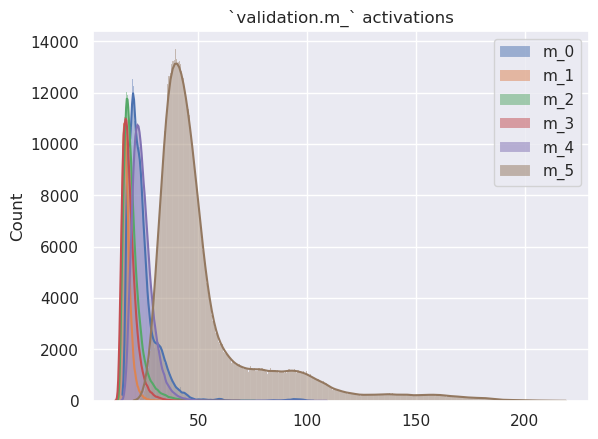

  0%|          | 0/6 [00:00<?, ?it/s]

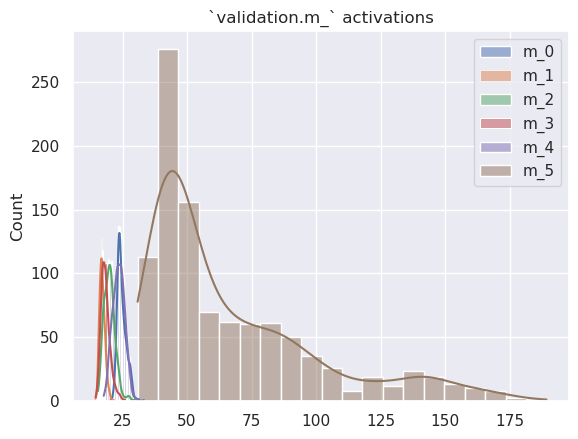

In [13]:
plot_stacked("validation.m_")
plot_averaged("validation.m_")

  0%|          | 0/6 [00:00<?, ?it/s]

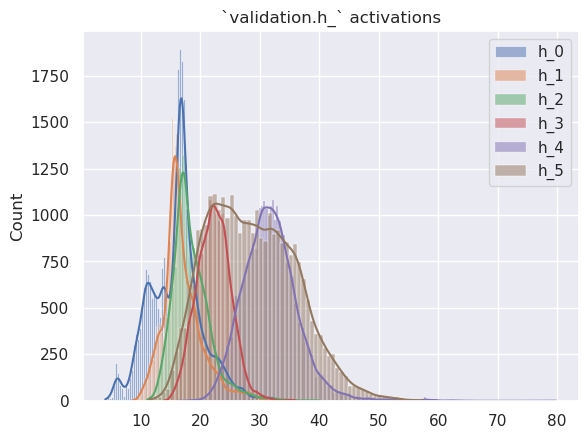

  0%|          | 0/6 [00:00<?, ?it/s]

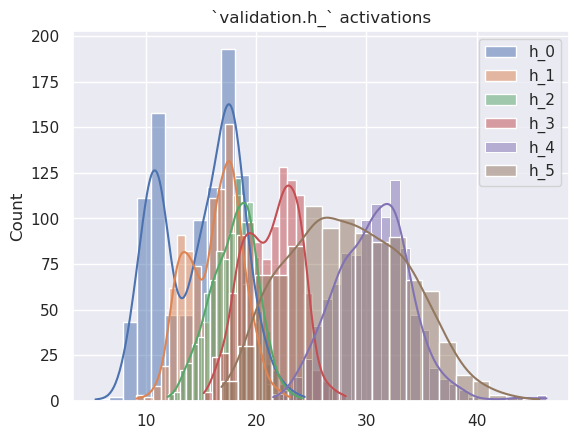

In [14]:
plot_stacked("validation.h_")
plot_averaged("validation.h_")

In [6]:
def process(act: np.ndarray):
    # Take norm of the final axis
    act = np.linalg.norm(act, axis=-1)
    return act


stacked = {
    act.name[len("validation.") :]: process(np.concatenate(act.all_activations()))
    for act in tqdm(acts_list)
}
rich.print(stacked)

{
    'm_0': array[887592] f32 3.4Mb x∈[15.190, 103.037] μ=24.186 σ=7.957,
    'm_1': array[887592] f32 3.4Mb x∈[12.948, 43.058] μ=17.137 σ=2.089,
    'm_2': array[887592] f32 3.4Mb x∈[12.717, 76.183] μ=19.687 σ=4.393,
    'm_3': array[887592] f32 3.4Mb x∈[11.775, 69.150] μ=18.334 σ=3.396,
    'm_4': array[887592] f32 3.4Mb x∈[14.470, 109.082] μ=24.427 σ=4.674,
    'm_5': array[887592] f32 3.4Mb x∈[20.290, 218.912] μ=54.242 σ=27.483
}

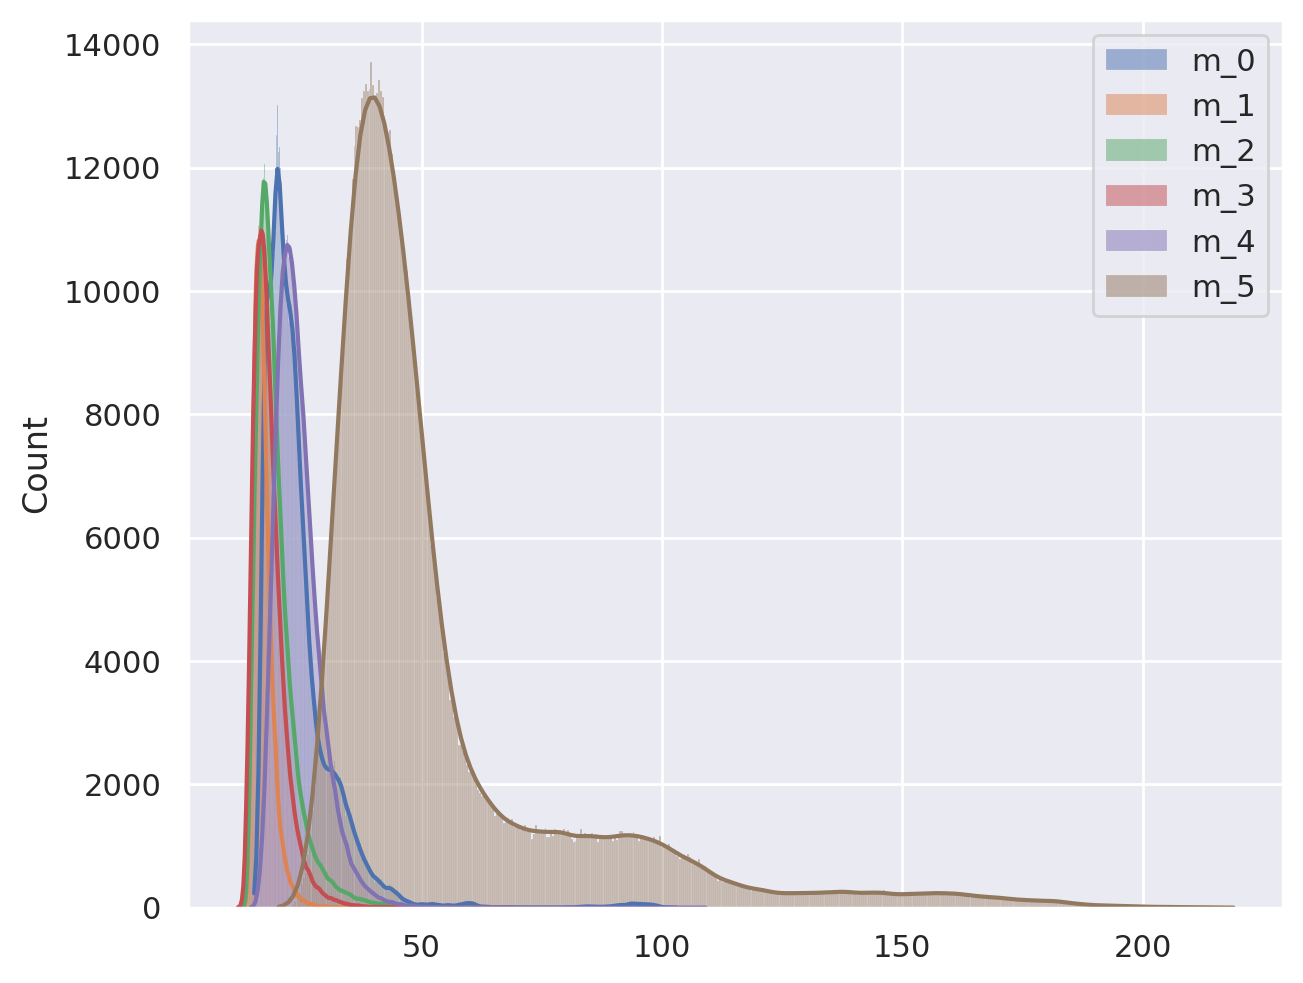

In [ ]:
# %%

# Plot a histogram of the activations, colored by the name of the activation

import seaborn as sns

sns.set_theme()

fig, ax = plt.subplots()
for name, m in stacked.items():
    sns.histplot(m, kde=True, label=name, ax=ax)

ax.legend()
plt.show()

In [ ]:
# %%

# prefix = "validation.m_"
prefix = "validation.h_"
acts_list = [act for act in acts if act.name.startswith(prefix)]
rich.print(acts_list)

[
    LoadedActivation(name='validation.h_0', num_activations=1024),
    LoadedActivation(name='validation.h_1', num_activations=1024),
    LoadedActivation(name='validation.h_2', num_activations=1024),
    LoadedActivation(name='validation.h_3', num_activations=1024),
    LoadedActivation(name='validation.h_4', num_activations=1024),
    LoadedActivation(name='validation.h_5', num_activations=1024)
]

In [ ]:
# %%

import lovely_numpy as ln
import numpy as np

ln.set_config(repr=ln.lovely)


def process(act: np.ndarray):
    # Take norm of the final axis
    act = np.linalg.norm(act, axis=-1)
    return act


stacked = {
    act.name[len("validation.") :]: process(np.concatenate(act.all_activations()))
    for act in acts_list
}
rich.print(stacked)

{
    'h_0': array[30392] f32 0.1Mb x∈[4.034, 33.007] μ=16.029 σ=4.368,
    'h_1': array[30392] f32 0.1Mb x∈[8.552, 34.202] μ=17.010 σ=3.364,
    'h_2': array[30392] f32 0.1Mb x∈[11.080, 40.006] μ=18.530 σ=3.267,
    'h_3': array[30392] f32 0.1Mb x∈[13.900, 36.119] μ=22.284 σ=2.841,
    'h_4': array[30392] f32 0.1Mb x∈[16.345, 79.845] μ=31.809 σ=4.683,
    'h_5': array[30392] f32 0.1Mb x∈[11.440, 57.608] μ=28.670 σ=7.319
}

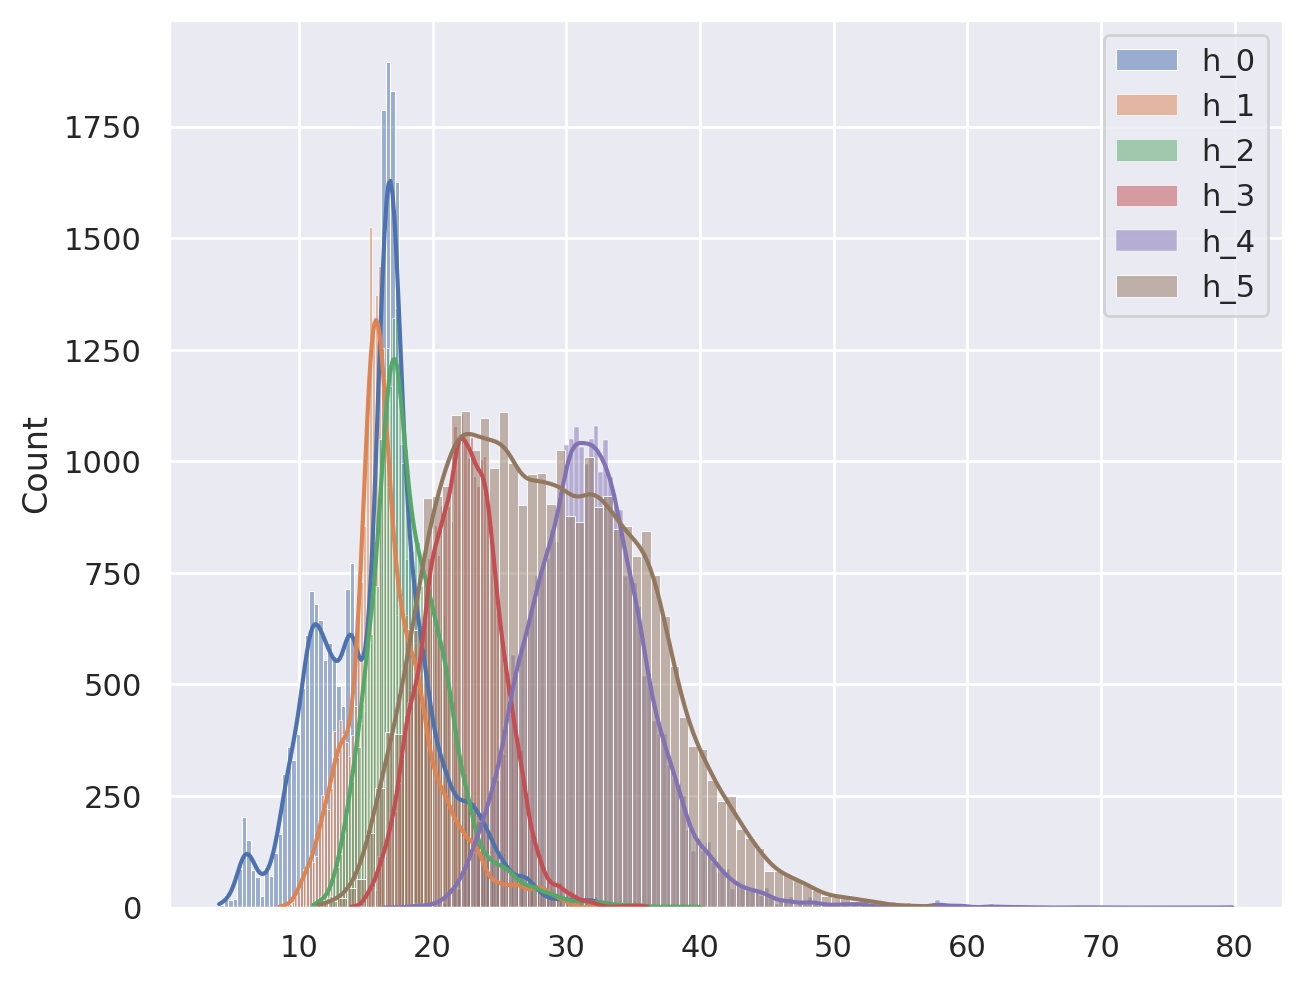

In [ ]:
# %%

# Plot a histogram of the activations, colored by the name of the activation

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

fig, ax = plt.subplots()
for name, m in stacked.items():
    sns.histplot(m, kde=True, label=name, ax=ax)

ax.legend()
plt.show()

In [ ]:
# %%

# prefix = "validation.m_"
# prefix = "validation.h_"
prefix = "validation.x_E_"
acts_list = [act for act in acts if act.name.startswith(prefix)]
rich.print(acts_list)

[
    LoadedActivation(name='validation.x_E_0', num_activations=1024),
    LoadedActivation(name='validation.x_E_1', num_activations=1024),
    LoadedActivation(name='validation.x_E_2', num_activations=1024),
    LoadedActivation(name='validation.x_E_3', num_activations=1024),
    LoadedActivation(name='validation.x_E_4', num_activations=1024),
    LoadedActivation(name='validation.x_E_5', num_activations=1024),
    LoadedActivation(name='validation.x_E_6', num_activations=1024),
    LoadedActivation(name='validation.x_E_final', num_activations=1024)
]

In [ ]:
# %%

import lovely_numpy as ln
import numpy as np

ln.set_config(repr=ln.lovely)


def process(act: np.ndarray):
    # Take norm of the final axis
    act = np.linalg.norm(act, axis=-1)
    return act


stacked = {
    act.name[len("validation.") :]: process(np.concatenate(act.all_activations()))
    for act in acts_list
}
rich.print(stacked)

{
    'x_E_0': array[30392] f32 0.1Mb x∈[4.418, 71.523] μ=14.780 σ=9.273,
    'x_E_1': array[30392] f32 0.1Mb x∈[2.792, 35.607] μ=7.197 σ=4.461,
    'x_E_2': array[30392] f32 0.1Mb x∈[2.451, 64.621] μ=7.781 σ=4.255,
    'x_E_3': array[30392] f32 0.1Mb x∈[3.110, 49.094] μ=6.481 σ=2.958,
    'x_E_4': array[30392] f32 0.1Mb x∈[3.544, 33.232] μ=6.278 σ=1.838,
    'x_E_5': array[30392] f32 0.1Mb x∈[3.742, 74.388] μ=7.527 σ=2.781,
    'x_E_6': array[30392] f32 0.1Mb x∈[2.163, 76.954] μ=4.852 σ=2.284,
    'x_E_final': array[30392] f32 0.1Mb x∈[1.437, 70.318] μ=5.453 σ=4.888
}

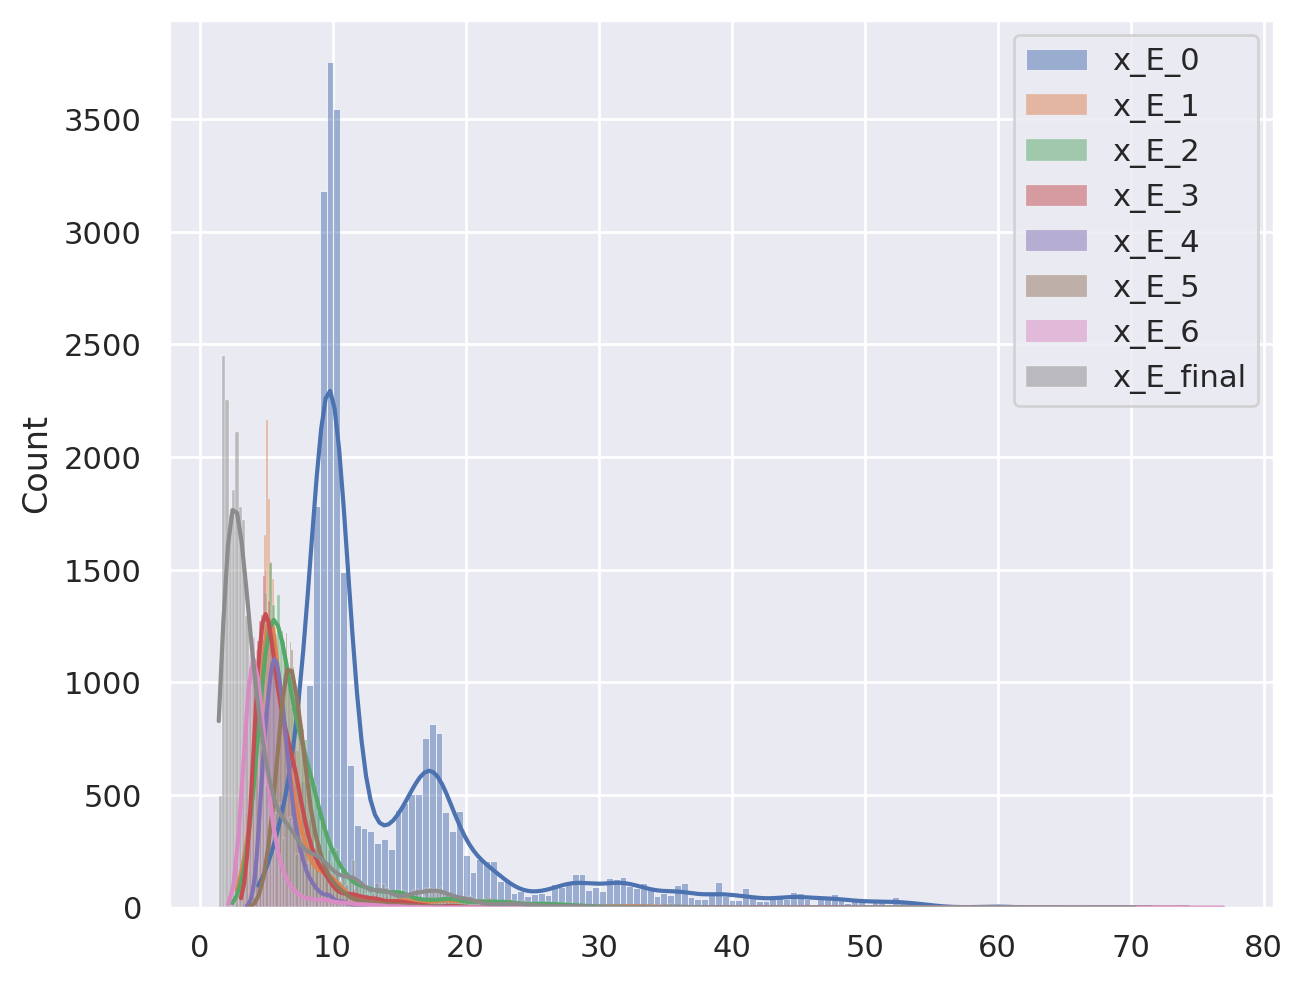

In [ ]:
# %%

# Plot a histogram of the activations, colored by the name of the activation

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

fig, ax = plt.subplots()
for name, m in stacked.items():
    sns.histplot(m, kde=True, label=name, ax=ax)

ax.legend()
plt.show()